# Predict and Visualize

In [5]:
import json
from tqdm import tqdm
import numpy as np
import os
import argparse

import torch
from torch import nn, optim
from torchvision import transforms as T
import json

from models import NTM
from task_generator import CopyDataset, AssociativeDataset, SequentialMNIST

## Task Data

In [3]:
# ==== Load the Task Configuration files ====
# Copy Task ===
task_params = json.load(open('configs/copy.json'))
task_params['min_seq_len'] = 60
task_params['max_seq_len'] = 120

# Associative Recall Task ===
# task_params['min_item'] = 6
# task_params['max_item'] = 9

In [4]:
# ==== Create Dataset ====
dataset = CopyDataset(task_params)

## Model

In [5]:
# ==== Create NTM ====
ntm = NTM(input_dim=task_params['seq_width'] + 2,
          output_dim=task_params['seq_width'],
          ctrl_dim=task_params['controller_size'],
          memory_units=task_params['memory_units'],
          memory_unit_size=task_params['memory_unit_size'],
          num_heads=task_params['num_heads'])

NTM Using device: cpu


In [6]:
# Load trained model weights
ntm.load_state_dict(torch.load('model_copy.pt'))

<All keys matched successfully>

## Prediction Step

In [9]:
# Reset
ntm.reset()

# Sample data
data = dataset[np.random.randint(65536)]
inputs, target = data['input'], data['target']

# Tensor to store outputs
out = torch.zeros(target.size())

# Process the inputs through NTM for memorization
for i in range(inputs.size()[0]):
    # Forward passing all sequences for read
    ntm(inputs[i].unsqueeze(0))

# Get the outputs from memory without real inputs
zero_inputs = torch.zeros(inputs.size()[1]).unsqueeze(0) # dummy inputs
for i in range(target.size()[0]):
    out[i] = ntm(zero_inputs)

# Calculate binary outputs
binary_output = out.clone()
binary_output = binary_output.detach().apply_(lambda x: 0 if x < 0.5 else 1)

# Sequence prediction error is calculted in bits per sequence
error = torch.sum(torch.abs(binary_output - target))
print(f'Error: {error} bits per sequence')

Error: 440.0 bits per sequence


## Visualize

In [10]:
# Transforms Compose object
visualize = T.Compose([T.ToPILImage(), T.Resize(128, interpolation=0)])

torch.Size([10, 118]) torch.Size([8, 116])


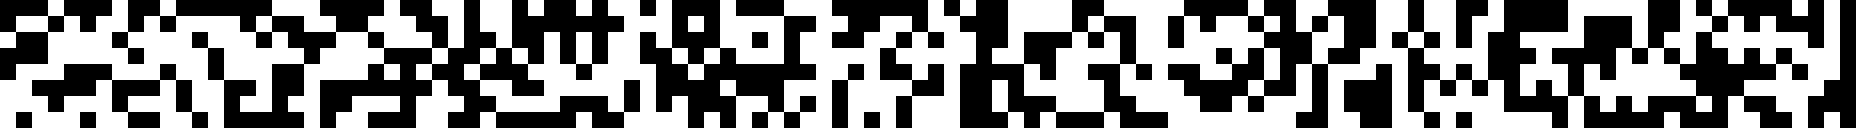

In [11]:
# Visualize Input
print(inputs.permute(1, 0).shape, inputs.permute(1, 0)[:-2, 2:].shape)
visualize(inputs.permute(1, 0)[:-2, 2:])

torch.Size([8, 116])


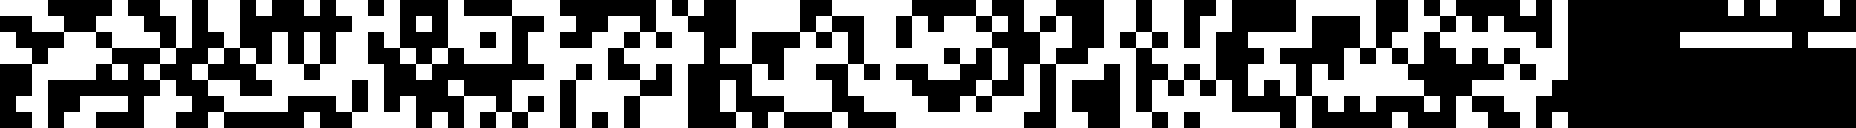

In [12]:
# Visualize Predicted Output
print(binary_output.permute(1, 0).shape)
visualize(binary_output.permute(1, 0))

# Sequential mnist

In [6]:
# load test dataset
from torch.utils.data import DataLoader
import json
task_params = json.load(open('checkpoints/ntm+lstm-seq_mnist-100-batch-12000-2024-06-0819:31:05.843406.json'))
task_params = task_params['parameters_task']
test_dataset = SequentialMNIST(task_params, train=False)
print(f"Number of samples: {len(test_dataset)}")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Number of samples: 10000


In [7]:
# ntm for seq mnist
ntm = NTM(input_dim=task_params['seq_width'],
            output_dim=task_params['output_dim'],
            ctrl_dim=task_params['controller_size'],
            memory_units=task_params['memory_units'],
            memory_unit_size=task_params['memory_unit_size'],
            num_heads=task_params['num_heads'], device="cpu")

NTM Using device: cpu


In [8]:
# Load your trained model
ntm.load_state_dict(torch.load('checkpoints/ntm+lstm-seq_mnist-100-batch-12000-2024-06-0819:31:05.843406.pth'))

<All keys matched successfully>

In [10]:
# Initialize variables to track accuracy
correct = 0
total = 0

ntm.eval()
from tqdm import tqdm

# Disable gradient calculation for evaluation
with torch.no_grad():
    for step, data in enumerate(tqdm(test_loader)):
        # Reset
        ntm.reset()
        
        # Move data and target to the appropriate device (e.g., GPU if available)
        inputs, target = data['input'], data['target']
        inputs = inputs.transpose(1, 0) # (seq_len, batch, input_dim)
        # print(inputs.shape, target.shape)

        for i in range(inputs.size()[0]):
            # Forward passing all sequences for read
            out = ntm(inputs[i])
        
        # Get the predicted class
        pred = out.argmax(dim=1, keepdim=True)
        # print(pred, target.view_as(pred))
        
        # Update the total number of correct predictions
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

# Calculate the accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')

100%|██████████| 10000/10000 [27:46<00:00,  6.00it/s]

Accuracy: 60.10%
